In [5]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm

In [6]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [7]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(27)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))


In [4]:
#So track IDs and corrresponding tracks are found in tracking df, 
#The corresponding points that made the circle are in arcos df, 
#the waves to analze are in waves df, need to go from 
#WaveDF --> arcosDF --> trackingDF 
#Get centroid and radius over time from waveDF, 
#Get trackID inside wavefront from arcosDF, 
#Get track from tracking, then calc radial movement as enter wavefront? 

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed i

<Axes: xlabel='timepoint', ylabel='circle_radius'>

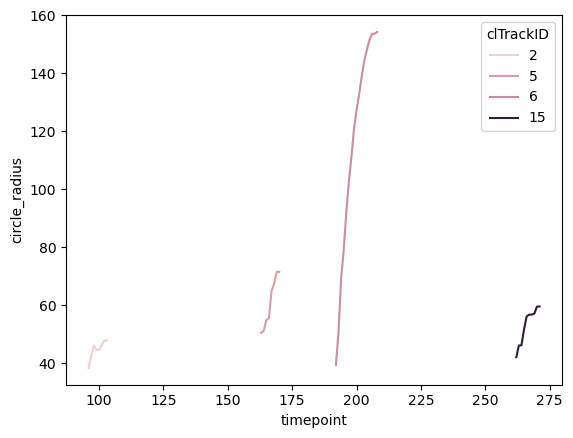

In [8]:
sns.lineplot(data=wave_df, x='timepoint', y='circle_radius', hue='clTrackID')

In [9]:
#Calc a stable centroid: 
#Only looking at clID that hvae waves mapped to them for now...

clIDs = wave_df.clTrackID.values

wave_ex = wave_df[wave_df.clTrackID == clIDs[2]]
arcos_ex =  arcos_df[arcos_df.clTrackID == clIDs[2]]

centroids = np.stack(wave_ex.wave_centroid.values, axis=0)
mean_centroid = (np.mean(centroids[:,0]), np.mean(centroids[:,1]))

In [11]:
arcos_slice = arcos_ex.groupby('timepoint')

In [12]:
window_start = arcos_ex['timepoint'].min() - 24
window_stop = arcos_ex['timepoint'].max() + 24

In [13]:
tracks = tracking_df.groupby('track_id')

In [14]:
#get the tracks that arcos says are inside the wave...
track_collect = []
outer_tracks = []

for i, track in tracks: 
    if i in arcos_ex.track_id.unique():
        track_collect.append(track[track['timepoint'].between(window_start, window_stop)])
    else:
        outer_tracks.append(track[track['timepoint'].between(window_start, window_stop)])
        
tracks_in_wave = pd.concat(track_collect, ignore_index=True)
tracks_out_wave = pd.concat(outer_tracks, ignore_index=True)

In [15]:
tiw = tracks_in_wave.track_id.unique()

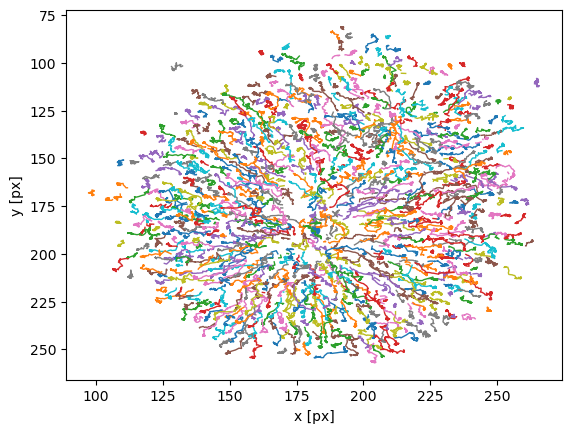

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [16]:
plt.plot(mean_centroid[0], mean_centroid[1], 'o')
tp.plot_traj(tracks_in_wave.rename(columns={'track_id':'particle'}), t_column='timepoint')


In [17]:
tracks_group = tracks_in_wave.groupby('track_id')
tracks_calc = []

for track_id, track in tqdm(tracks_group):
    #Get the time, x, and y points --> Smooth x and y on time... 
    time = track.timepoint.values*5.0
    x_smooth = UnivariateSpline(time, track.x.values, s=5)
    y_smooth = UnivariateSpline(time, track.y.values, s=5)
    
    #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
    coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
    lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
    radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
    dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
    velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
    angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
    cis = np.cos(angles)
    radial_velocity = velocity*cis

    #Integrate calcium signal over mean?
    int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())
    
    #Append the relevant parameters to the track: 
    track['radial_dist'] = dist_from_center
    track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
    track['integrated_calcium'] = int_cal
    track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
    track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
    track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
    track['wave_center_distance'] = dist_from_center
    track['max_calcium'] = track['Calcium'].max()
    tracks_calc.append(track)
    
tracks_calculated_df = pd.concat(tracks_calc, ignore_index=True)

100%|██████████████████████████████████████████| 807/807 [00:01<00:00, 798.08it/s]


In [18]:
out_group = tracks_out_wave.groupby('track_id')
out_calc = []

track_min_length = 5

for track_id, track in tqdm(out_group):
    
    if len(track) < track_min_length:
        continue
    
    #Get the time, x, and y points --> Smooth x and y on time... 
    time = track.timepoint.values*5.0
    x_smooth = UnivariateSpline(time, track.x.values, s=5)
    y_smooth = UnivariateSpline(time, track.y.values, s=5)
    
    #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
    coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
    lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
    radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
    dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
    velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
    angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
    cis = np.cos(angles)
    radial_velocity = velocity*cis

    #Append the relevant parameters to the track:
    track['radial_dist'] = dist_from_center
    track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
    track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
    track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
    track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
    track['wave_center_distance'] = dist_from_center
    out_calc.append(track)
    
outer_calculated_df = pd.concat(out_calc, ignore_index=True)

100%|████████████████████████████████████████| 6698/6698 [00:12<00:00, 556.07it/s]


In [19]:
#Shift time-column so that 0 is when arcos event starts also convert frames to seconds: 
wave_start = arcos_ex.timepoint.values[0]


tracks_calculated_df['shift_time'] = (5.0/60.0)*(tracks_calculated_df['timepoint'] - wave_start)
outer_calculated_df['shift_time'] = (5.0/60.0)*(outer_calculated_df['timepoint'] - wave_start)


In [20]:
print("inner tracks: {}".format(len(tracks_calculated_df.track_id.unique())))
print("outer tracks: {}".format(len(outer_calculated_df.track_id.unique())))

inner tracks: 807
outer tracks: 6555


In [21]:
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5, 'font.family': ['arial'], 'axes.linewidth':2})

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

Text(0.5, 0, '')

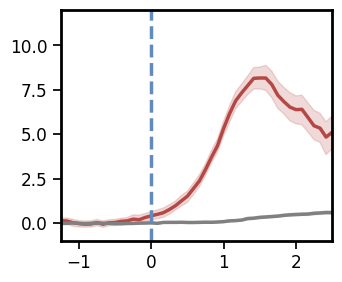

In [23]:
fig = plt.subplots(figsize=(3.5,3))
sns.lineplot(data=tracks_calculated_df, x='shift_time', y='radial_velocity', color ="#B54845", legend=False)
sns.lineplot(data=outer_calculated_df, x='shift_time', y='radial_velocity', color='grey', legend=False)
#sns.lineplot(data=tracks_calculated_df, x='timepoint', y='Calcium', color='#e5097f', ax=ax1, label='Wave Calcium Signal', legend=False)
plt.vlines(0, -1, 12.5, linestyles='dashed', colors='#628BBD', label='Wave Initiated')


plt.ylim(-1,12)
plt.xlim(-1.25,2.5)
plt.ylabel('')
plt.xlabel('')

#TO PLOT FIGURE AND SAVE UNCOMMENT BELOW
#plt.savefig('fig-1-bulk-movement.png', bbox_inches='tight', dpi=300)